In [1]:
using LinearAlgebra
include("../src/QuSP.jl")
using Main.QuSP.TimeEvolvingBlockDecimation
using Main.QuSP.MatrixProductState

In [2]:
sites = 8
ψ = zeros(2^sites)
ψ[2^sites] = 1;

In [3]:
⊗ = kron
I = [1 0; 0 1]
σ_x = [0 1; 1 0]
σ_y = [0 -1im; 1im 0]
σ_z = [1 0; 0 -1]

t = π / 6;

In [4]:
function ising_matrix(sites::Integer, J::Number)
        I = [
            1 0
            0 1
        ]
        identity_string = [I for _ = 1:sites]
        local_term = zeros(2^sites, 2^sites)
        interaction_term = zeros(2^sites, 2^sites)

        for i = 1:sites
            pauli_string = copy(identity_string)
            pauli_string[i] = σ_x
            local_term += reduce(kron, pauli_string)
        end

        for i = 1:sites-1
            pauli_string = copy(identity_string)
            pauli_string[i] = σ_z
            pauli_string[i+1] = σ_z
            interaction_term += reduce(kron, pauli_string)
        end
        return interaction_term + J * local_term
end

function full_time_evolve(ψ, J, t)
    H = ising_matrix(sites, J)
    return exp(H * t * -1im) * ψ
end

function tebd_time_evolve(ψ, H, t, χ)
    ψ_t = reshape(ψ, (2 for _=1:sites)...)
    ψ_mps = mps(ψ_t, χ)
    return reshape(contract_mps(tebd(ψ_mps, ising, t * -1im, 50)), 2^sites)
end

tebd_time_evolve (generic function with 1 method)

In [5]:
J=1
ising = Hamiltonian(J * (σ_z ⊗ σ_z), σ_x)
function get_fidelities(χ)
    res = 50
    fidelities = zeros(res)
    for t = 1:res
        ψ1 = full_time_evolve(ψ, 1, 2*π/res * t)
        ψ2 = tebd_time_evolve(ψ, ising, 2*π/res * t, χ)
        fidelities[t] = abs(dot(ψ1, ψ2))
    end
    return fidelities
end

get_fidelities (generic function with 1 method)

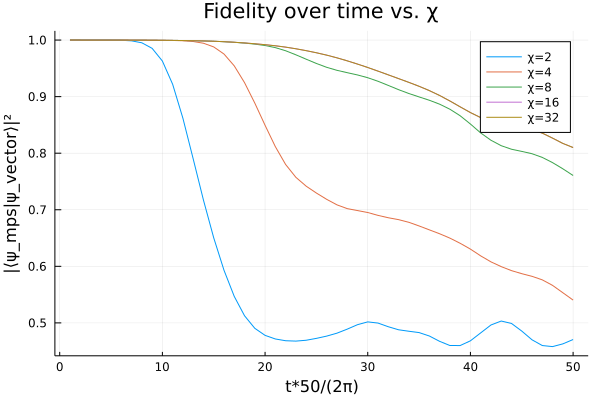

In [6]:
using Plots

chis = [4, 8, 16, 32]
fidelities = get_fidelities(2)
res=50
p = plot(1:res,
    fidelities,
    label="χ=2",
    xlabel="t*50/(2π)",
    ylabel="|⟨ψ_mps|ψ_vector⟩|²",
    title="Fidelity over time vs. χ")
for chi in chis
    plot!(p, 1:res, get_fidelities(chi), label="χ="*string(chi))
end
display(p)

In [7]:
using Einsum

function get_bipartite_entanglement(ψ, J, t)
    ψ = full_time_evolve(ψ, J, t)
    ψ_t = reshape(ψ, (2 for _=1:sites)...)
    ψ_t_d = conj(ψ_t)
    @einsum ρ[a, b, c, d, e, f, g, h] := ψ_t[a, b, c, d, i, j, k, l] * ψ_t_d[e, f, g, h, i, j, k, l]
    ρ = reshape(ρ, 16, 16)
    #print([λ for λ in round.(eigvals(ρ), digits=10) if λ != 0])
    return -sum([λ*log(λ) for λ in round.(eigvals(ρ), digits=10) if λ != 0])
end

get_bipartite_entanglement (generic function with 1 method)

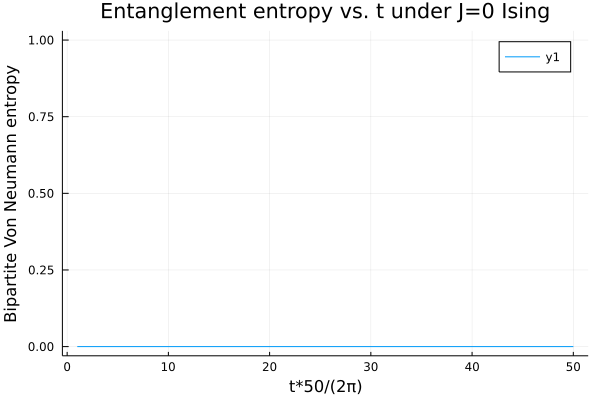

In [8]:
res = 50
J=0
entropies = zeros(res)
for t = 1:res
    entropies[t] = get_bipartite_entanglement(ψ, J, t)
end
p = plot(1:res,
    entropies,
    xlabel="t*50/(2π)",
    ylabel="Bipartite Von Neumann entropy",
    title="Entanglement entropy vs. t under J=0 Ising")

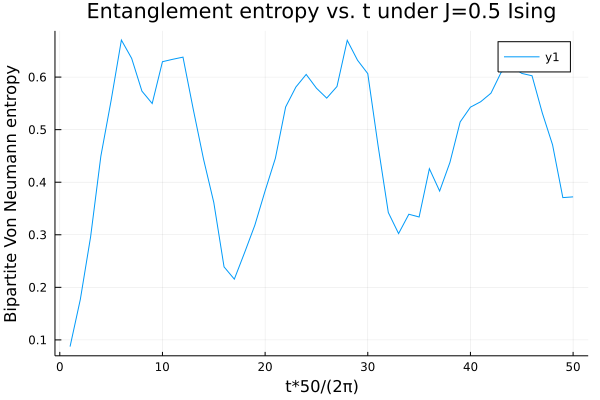

In [9]:
res = 50
J=0.5
entropies = zeros(res)
for t = 1:res
    entropies[t] = get_bipartite_entanglement(ψ, J, t)
end
p = plot(1:res,
    entropies,
    xlabel="t*50/(2π)",
    ylabel="Bipartite Von Neumann entropy",
    title="Entanglement entropy vs. t under J=0.5 Ising")

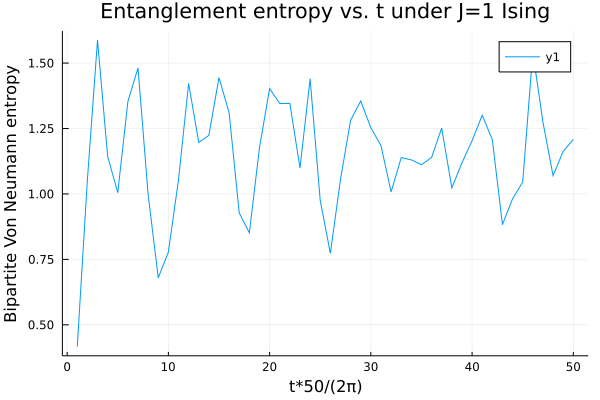

In [10]:
res = 50
J=1
entropies = zeros(res)
for t = 1:res
    entropies[t] = get_bipartite_entanglement(ψ, J, t)
end
p = plot(1:res,
    entropies,
    xlabel="t*50/(2π)",
    ylabel="Bipartite Von Neumann entropy",
    title="Entanglement entropy vs. t under J=1 Ising")

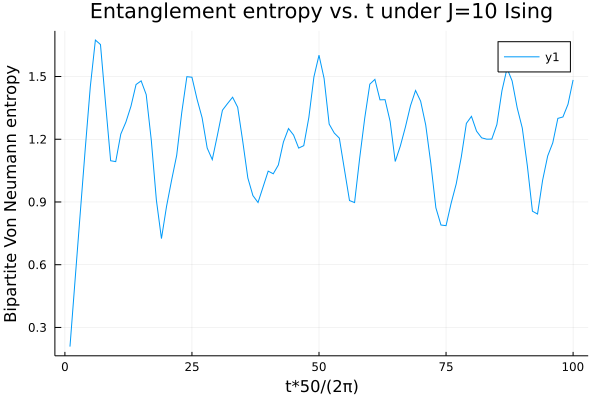

In [11]:
res = 100
J=10
entropies = zeros(res)
for t = 1:res
    entropies[t] = get_bipartite_entanglement(ψ, J, t/2)
end
p = plot(1:res,
    entropies,
    xlabel="t*50/(2π)",
    ylabel="Bipartite Von Neumann entropy",
    title="Entanglement entropy vs. t under J=10 Ising")